In [1]:
import os
import yaml
import torch
from tqdm import tqdm

os.chdir('..')
from inference.utils import *
from core.utils import load_or_fail
from train import LoraCore, WurstCoreB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load Config

In [2]:
# SETUP STAGE C
config_file = 'configs/inference/lora_c_3b.yaml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)

core = LoraCore(config_dict=loaded_config, device=device, training=False)

# SETUP STAGE B
config_file_b = 'configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core_b = WurstCoreB(config_dict=config_file_b, device=device, training=False)

['model_version', 'effnet_checkpoint_path', 'previewer_checkpoint_path', 'module_filters', 'rank', 'train_tokens']
['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']


### Load Extras & Models

In [3]:
extras = core.setup_extras_pre()
models = core.setup_models(extras)
models.generator.bfloat16().eval().requires_grad_(False)
print("STAGE C WITH LORA READY")

extras_b = core_b.setup_extras_pre()
models_b = core_b.setup_models(extras_b, skip_clip=True)
models_b = WurstCoreB.Models(
   **{**models_b.to_dict(), 'tokenizer': models.tokenizer, 'text_model': models.text_model}
)
models_b.generator.bfloat16().eval().requires_grad_(False)
print("STAGE B READY")

['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Updating tokens: [(49408, '[fernando]')]
LoRA training 128 layers
['tokenizer', 'text_model', 'generator', 'effnet', 'previewer', 'lora']
STAGE C WITH LORA READY
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
STAGE B READY


### Optional: Compile Stage C and Stage B

**Note**: This will increase speed inference by about 2x, but will initially take a few minutes to compile. Moreover, currently using `torch.compile` only works for a single image resolution, e.g. 1024 x 1024. If you use a different size, it will recompile. See more [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

In [ ]:
models = LoraCore.Models(
   **{**models.to_dict(), 'generator': torch.compile(models.generator, mode="reduce-overhead", fullgraph=True)}
)

models_b = WurstCoreB.Models(
   **{**models_b.to_dict(), 'generator': torch.compile(models_b.generator, mode="reduce-overhead", fullgraph=True)}
)

## LoRA Inference

100%|███████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s]


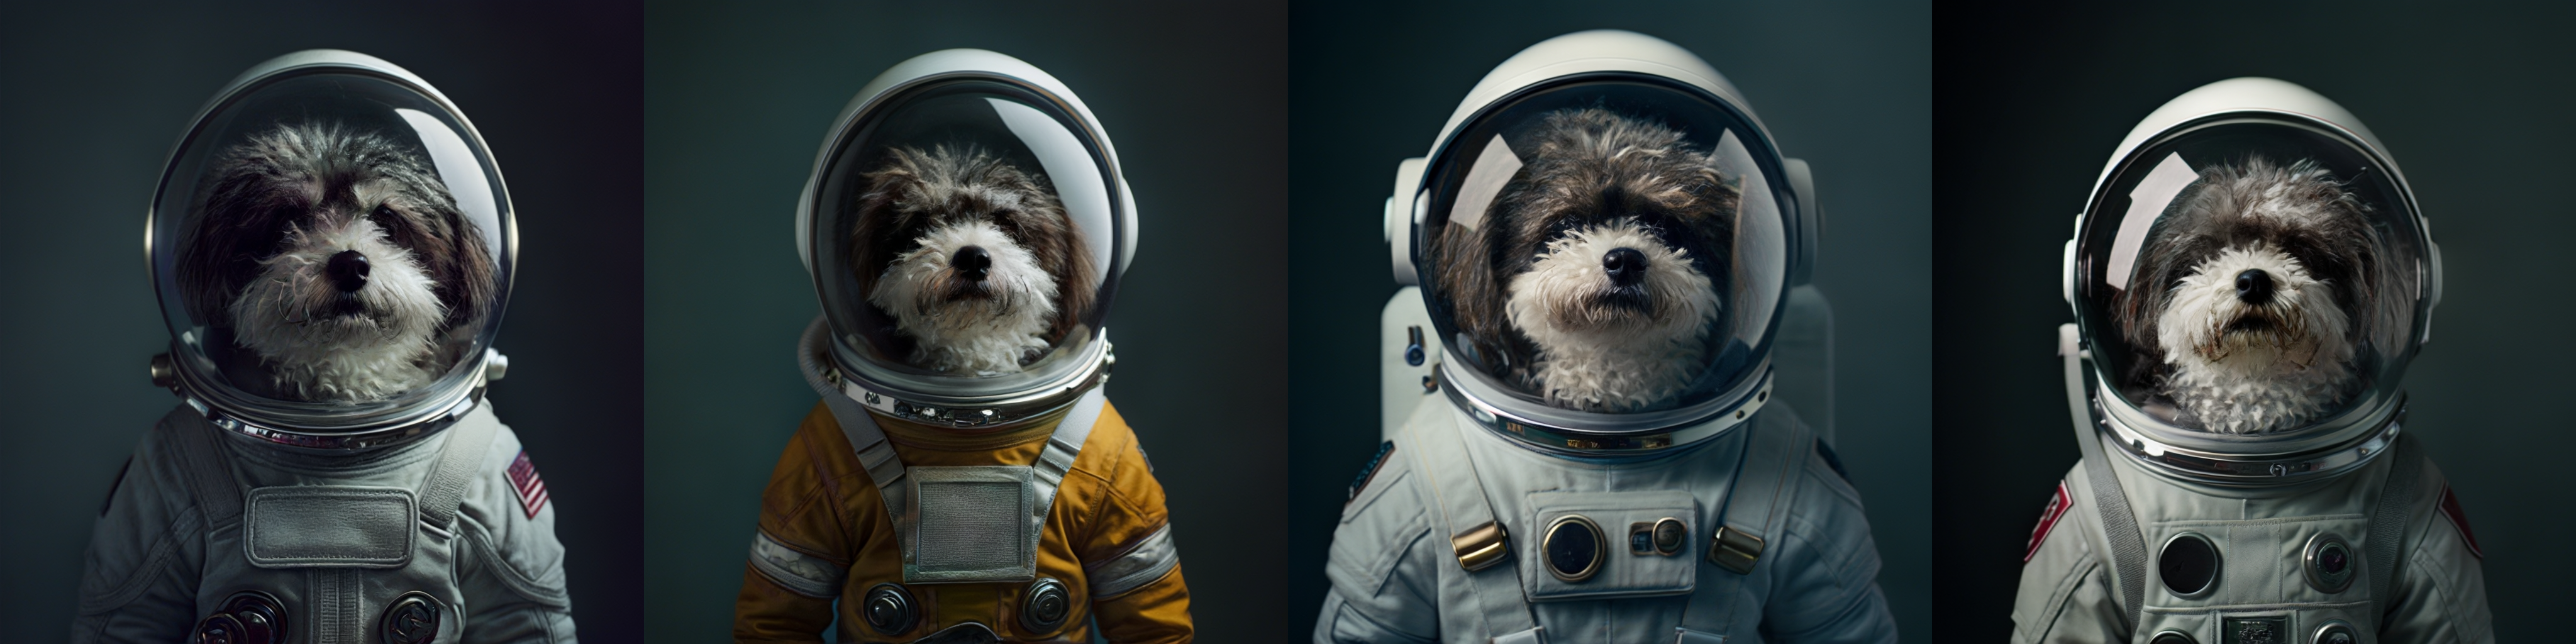

In [5]:
batch_size = 4
caption = "cinematic photo of a dog [fernando] wearing a space suit"
height, width = 1024, 1024
stage_c_latent_shape, stage_b_latent_shape = calculate_latent_sizes(height, width, batch_size=batch_size)

# Stage C Parameters
extras.sampling_configs['cfg'] = 4
extras.sampling_configs['shift'] = 2
extras.sampling_configs['timesteps'] = 20
extras.sampling_configs['t_start'] = 1.0

# Stage B Parameters
extras_b.sampling_configs['cfg'] = 1.1
extras_b.sampling_configs['shift'] = 1
extras_b.sampling_configs['timesteps'] = 10
extras_b.sampling_configs['t_start'] = 1.0

# PREPARE CONDITIONS
batch = {'captions': [caption] * batch_size}
conditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
conditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    # torch.manual_seed(42)

    sampling_c = extras.gdf.sample(
        models.generator, conditions, stage_c_latent_shape,
        unconditions, device=device, **extras.sampling_configs,
    )
    for (sampled_c, _, _) in tqdm(sampling_c, total=extras.sampling_configs['timesteps']):
        sampled_c = sampled_c
        
    # preview_c = models.previewer(sampled_c).float()
    # show_images(preview_c)

    conditions_b['effnet'] = sampled_c
    unconditions_b['effnet'] = torch.zeros_like(sampled_c)

    sampling_b = extras_b.gdf.sample(
        models_b.generator, conditions_b, stage_b_latent_shape,
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    for (sampled_b, _, _) in tqdm(sampling_b, total=extras_b.sampling_configs['timesteps']):
        sampled_b = sampled_b
    sampled = models_b.stage_a.decode(sampled_b).float()

show_images(sampled)